# Clean Citation Data from Scopus

This notebook processes and cleans citation data from Scopus reference files. It performs the following tasks:

1. **Data Loading**: Reads JSON files containing Scopus reference data from the `../data/01-raw/scopus/references/` directory.

2. **Reference Extraction**: The `ReadAndExtractRefs` class processes the JSON files to:
   - Extract Scopus EIDs (Electronic Identifiers) from reference data
   - Handle both single reference (dict) and multiple references (list) formats
   - Create a mapping between document IDs and their reference EIDs

3. **Data Storage**: Saves the processed reference data as a JSON file at `../data/02-clean/references/eid_reference_dict.json`

The output is a dictionary where:
- Keys are document IDs
- Values are lists of Scopus EIDs for the references cited in each document

This cleaned data will be used for further citation network analysis and bibliometric studies.

In [4]:
from dotenv import load_dotenv
import os
import pandas as pd
import glob
import json
from tqdm import tqdm
import numpy as np
import datetime

# Load environment variables from .env file
load_dotenv()

# Access environment variables
python_path = os.getenv('PYTHONPATH')
data_dir = os.getenv('DATA_DIR')
src_dir = os.getenv('SRC_DIR')
output_dir = os.getenv('OUTPUT_DIR')

In [2]:


class ReadAndExtractRefs:
    """
    Class to read and extract references from Scopus reference files.
    Args:
        path_to_ref_files (str): Path to the directory containing the reference files.
    """
    def __init__(self, path_to_ref_files="."):
        self.path_to_ref_files = path_to_ref_files
        # Add trailing slash if missing
        if not self.path_to_ref_files.endswith("/"):
            self.path_to_ref_files += "/"
        self.files = glob.glob(self.path_to_ref_files + "*.json")
        self.final_eid_reference_dict = {}
        self.raw_reference_dict = {}  # Store raw JSON data

    def read_json_file(self, filename: str) -> dict:
        """
        Read and parse a JSON file.
        Args:
            filename (str): Path to JSON file
        Returns:
            dict: Parsed JSON data or None if error
        """
        try:
            with open(filename, "r") as f:
                return json.load(f)
        except FileNotFoundError:
            print(f"File not found: {filename}")
        except json.JSONDecodeError:
            print(f"Error decoding JSON in file: {filename}")
        return None

    def extract_eid_from_reference(self, reference) -> str:
        """
        Extract EID from a single reference.
        Args:
            reference (dict): Reference data
        Returns:
            str: Scopus EID or None
        """
        if isinstance(reference, dict):
            return reference.get("scopus-eid")
        return None

    def extract_eids(self, data: dict) -> None:
        """
        Extracts Scopus EIDs from the reference data.
        Args:
            data (dict): Dictionary containing reference data.
        """
        for key, value in data.items():
            # Store raw data
            self.raw_reference_dict[key] = value

            if not value:
                self.final_eid_reference_dict[key] = np.nan
                continue

            if isinstance(value, dict):
                eid = self.extract_eid_from_reference(value)
                self.final_eid_reference_dict[key] = [eid] if eid else np.nan
            else:
                eids = [eid for eid in map(self.extract_eid_from_reference, value) if eid is not None]
                self.final_eid_reference_dict[key] = eids if eids else np.nan

    def run(self) -> tuple[dict, dict]:
        """
        Process all reference files and extract EIDs.
        Returns:
            tuple: (Dictionary mapping document IDs to lists of reference EIDs or np.nan if no references,
                   Dictionary containing raw reference data)
        """
        for file in tqdm(self.files):
            if data := self.read_json_file(file):
                self.extract_eids(data)
        return self.final_eid_reference_dict, self.raw_reference_dict

In [4]:
path_to_ref_files = data_dir + "/01-raw/references/scopus/"

extractor = ReadAndExtractRefs(path_to_ref_files)
final_eid_reference_dict, raw_reference_dict= extractor.run()

100%|██████████| 86/86 [11:04<00:00,  7.73s/it]


In [5]:
len(final_eid_reference_dict.keys())

38961

In [7]:
# save it to json
p = data_dir + "/02-clean/references/eid_reference_dict_20250328.json"
p_raw = data_dir + "/02-clean/references/raw_eid_reference_dict_20250328.json"


with open(p, "w") as f:
    json.dump(final_eid_reference_dict, f, indent=4)
with open(p_raw, "w") as f:
    json.dump(raw_reference_dict, f, indent=4)



# not using this below

# Missings from Scopus

example pmid:
Found 165 references for PMID 30091808:

In [8]:

final_eid_reference_dict = json.load(open(data_dir + "/02-clean/references/eid_reference_dict_20250328.json"))


# find eids with missing references
missing_eids = [k for k, v in final_eid_reference_dict.items() if isinstance(v, float)]
print(f"Total number of missing EIDs: {len(missing_eids)}")

# read article dat
df_article = pd.read_pickle(data_dir + "/02-clean/articles/scopus_cleaned_20250326_081230.pkl")

# filter for missing eids
df_article_missing = df_article[df_article['eid'].isin(missing_eids)]
pmid_of_missing = df_article_missing['pubmed_id'].unique()

# Handle NaN values before converting to int
pmid_of_missing = df_article_missing['pubmed_id'].dropna().unique().astype(int).tolist()
print(f"Number of PMIDs after handling NaN: {len(pmid_of_missing)}")


Total number of missing EIDs: 1906
Number of PMIDs after handling NaN: 1440


In [18]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import re
import time
from tqdm import tqdm
import logging
from typing import Dict, List, Optional, Union, Tuple

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("pubmed_reference_extraction.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def extract_identifiers(citation_text: str) -> Dict[str, Optional[str]]:
    """
    Extract DOI and PubMed ID from a citation text.

    Args:
        citation_text (str): The citation text containing identifiers

    Returns:
        dict: Dictionary with 'doi' and 'pmid' keys
    """
    # Initialize results
    result = {
        'doi': None,
        'pmid': None
    }

    if not citation_text or not isinstance(citation_text, str):
        return result

    # Extract DOI - looking for pattern like "DOI: 10.1186/1744-9081-5-34"
    doi_match = re.search(r'DOI:\s*(10\.[0-9]+/[^\s\]\;]+)', citation_text)
    if doi_match:
        result['doi'] = doi_match.group(1)

    # Extract PubMed ID - looking for pattern like "PUBMED: 19650932"
    pmid_match = re.search(r'PUBMED:\s*([0-9]+)', citation_text)
    if pmid_match:
        result['pmid'] = pmid_match.group(1)

    return result

def get_article_references(pmid: Union[str, int]) -> List[Dict[str, any]]:
    """
    Retrieve references of an article using its PubMed ID.

    Args:
        pmid (str or int): PubMed ID of the article

    Returns:
        list: List of dictionaries containing reference information
    """
    # Base URLs for NCBI E-utilities
    eutils_base = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils"
    efetch_url = f"{eutils_base}/efetch.fcgi"

    # Make the API request
    params = {
        "db": "pubmed",
        "id": str(pmid),
        "retmode": "xml",
        "rettype": "abstract"
    }

    try:
        response = requests.get(efetch_url, params=params)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        logger.error(f"Error fetching data for PMID {pmid}: {str(e)}")
        return []

    # Parse the XML response
    try:
        tree = ET.fromstring(response.content)
    except ET.ParseError as e:
        logger.error(f"Error parsing XML for PMID {pmid}: {str(e)}")
        return []

    # Extract references
    references = []
    ref_list = tree.findall(".//ReferenceList/Reference")

    for ref in ref_list:
        ref_data = {}

        # Extract citation info
        citation = ref.find("Citation")
        if citation is not None:
            citation_text = citation.text if citation.text else ""

            # Extract DOI and PubMed ID from citation text
            if citation_text:
                identifiers = extract_identifiers(citation_text)
                ref_data["doi"] = identifiers["doi"]
                ref_data["pmid"] = identifiers["pmid"]
                ref_data["citation"] = citation_text

        # Keep only entries with at least one identifier
        if ref_data.get('doi') or ref_data.get('pmid'):
            references.append(ref_data)

    return references

def fetch_missing_references(pmid_list=None, output_file=None, batch_size=250):
    """
    Fetch missing references in batches and save progress.

    Args:
        pmid_list (list, optional): List of PubMed IDs to process.
        output_file (str, optional): Path to save the results.
        batch_size (int, optional): Number of PMIDs per batch. Default is 250.

    Returns:
        dict: Dictionary mapping EIDs to their references.
    """
    if pmid_list is None or not pmid_list:
        logger.warning("No PMIDs provided.")
        return {}

    logger.info(f"Processing {len(pmid_list)} PubMed IDs in batches of {batch_size}.")

    references_dict = {}

    for i in range(0, len(pmid_list), batch_size):
        batch_pmids = pmid_list[i:i + batch_size]
        logger.info(f"Processing batch {i // batch_size + 1} with {len(batch_pmids)} PMIDs.")

        for pmid in tqdm(batch_pmids, desc=f"Batch {i // batch_size + 1}"):
            try:
                references = get_article_references(pmid)
                references_dict[pmid] = references
                time.sleep(0.5)  # Be nice to NCBI API

            except Exception as e:
                logger.error(f"Error processing PMID {pmid}: {str(e)}")

        # Save batch results
        if output_file:
            pd.to_pickle(references_dict, output_file)
            logger.info(f"Saved {len(references_dict)} references to {output_file} after batch {i // batch_size + 1}.")

    return references_dict

Total number of missing EIDs: 1906


/var/folders/6m/zjbwrdgj0bg9zyhx3l7134mm0000gn/T/ipykernel_18912/1268284782.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_article_missing['year'] = df_article_missing['year'].astype(int)


NameError: name 'plt' is not defined

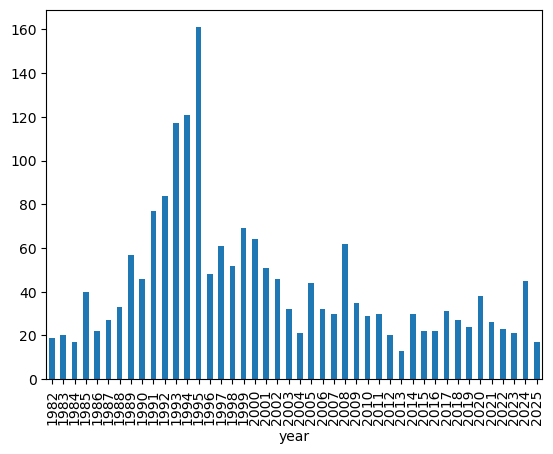

In [29]:

final_eid_reference_dict = json.load(open(data_dir + "/02-clean/references/eid_reference_dict_20250328.json"))


# find eids with missing references
missing_eids = [k for k, v in final_eid_reference_dict.items() if isinstance(v, float)]
print(f"Total number of missing EIDs: {len(missing_eids)}")

# read article dat
df_article = pd.read_pickle(data_dir + "/02-clean/articles/scopus_cleaned_20250326_081230.pkl")

# filter for missing eids
df_article_missing = df_article[df_article['eid'].isin(missing_eids)]

# plot missing counst per year

df_article_missing['year'] = df_article_missing['year'].astype(int)
# sort by year
df_article_missing['year'].value_counts().sort_index()


pmid_of_missing = df_article_missing['pubmed_id'].unique()

# Handle NaN values before converting to int
pmid_of_missing = df_article_missing['pubmed_id'].dropna().unique().astype(int).tolist()
print(f"Number of PMIDs after handling NaN: {len(pmid_of_missing)}")


In [30]:
pmid_of_missing[1000:1010]

[19450347,
 18323753,
 18362870,
 18668017,
 18312029,
 18300611,
 18332679,
 18622371,
 18397687,
 18570170]

In [25]:
import random
# subset of pmid list
lil_missing = pmid_of_missing[random.randint(0, len(pmid_of_missing) - 1)]
lil_missing.append(30091808)  # Then append to the list

print(lil_missing)

AttributeError: 'int' object has no attribute 'append'

In [20]:
# Run the process with your list of PMIDs
references = fetch_missing_references(pmid_list=lil_missing, output_file=data_dir + f"/01-raw/references/pubmed/pubmed_references_dict_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}.pkl", batch_size=250)

# Print some stats
print(f"Retrieved references for {len(references)} articles")


2025-04-01 15:00:24,687 - __main__ - INFO - Processing 11 PubMed IDs in batches of 250.
2025-04-01 15:00:24,689 - __main__ - INFO - Processing batch 1 with 11 PMIDs.
Batch 1: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]
2025-04-01 15:00:35,118 - __main__ - INFO - Saved 11 references to data/01-raw/references/pubmed/pubmed_references_dict_20250401_1500.pkl after batch 1.


Retrieved references for 11 articles


In [21]:
references

{3795084: [],
 2950994: [],
 3816412: [],
 2447901: [],
 2443644: [],
 3475452: [],
 3031276: [],
 3307982: [],
 3501993: [],
 3501994: [],
 30091808: [{'doi': '10.1186/1744-9081-5-34',
   'pmid': '19650932',
   'citation': 'Adler LA, Goodman D, Weisler R, Hamdani M, Roth T. Effect of lisdexamfetamine dimesylate on sleep in adults with attention‐deficit/hyperactivity disorder. Behavioral and Brain Functions 2009;5:34‐47. [DOI: 10.1186/1744-9081-5-34; NCT00334880; PMC2732626; PUBMED: 19650932]'},
  {'doi': None,
   'pmid': '19012818',
   'citation': 'Adler LA, Goodman DW, Kollins SH, Weisler RH, Krishnan S, Zhang Y, et al. Double‐blind, placebo‐controlled study of the efficacy and safety of lisdexamfetamine dimesylate in adults with attention‐deficit/hyperactivity disorder. Journal of Clinical Psychiatry 2008;69(9):1364‐73. [NCT00334880; PUBMED: 19012818]'},
  {'doi': '10.1186/2050-6511-13-18',
   'pmid': '23254273',
   'citation': 'Babcock T, Dirks B, Adeyi B, Scheckner B. Efficacy of 

In [22]:
refs = pd.read_pickle(data_dir + f"/01-raw/references/pubmed/pubmed_references_dict_20250331_2020.pkl")



In [23]:
refs['30091808']

KeyError: '30091808'

In [12]:
refs

{6121785: [],
 6210771: [],
 7099140: [],
 6953233: [],
 7096685: [],
 7090895: [],
 6124090: [],
 6979001: [],
 6303479: [],
 6808118: [],
 6808072: [],
 7099139: [],
 6753514: [],
 6218507: [],
 7080902: [],
 6183414: [],
 6809683: [],
 6753512: [],
 6230893: [],
 6230897: [],
 6230892: [],
 6236068: [],
 6223233: [],
 6310078: [],
 6230894: [],
 6189599: [],
 6140805: [],
 6230898: [],
 6227204: [],
 6230895: [],
 6604264: [],
 6411017: [],
 6220681: [],
 6230896: [],
 6306746: [],
 6223135: [],
 6141918: [],
 6362443: [],
 6384203: [],
 6150107: [],
 6089162: [],
 6086881: [],
 6591152: [],
 6598490: [],
 6610522: [],
 6427449: [],
 6233622: [],
 6205146: [],
 6323674: [],
 3006431: [],
 2995641: [],
 2582112: [],
 3890180: [],
 3882682: [],
 3871767: [],
 3882678: [],
 3933601: [],
 3161015: [],
 3882681: [],
 3882680: [],
 3156126: [],
 3156646: [],
 3866221: [],
 2579697: [],
 3008134: [],
 3874037: [],
 4020424: [],
 3882679: [],
 2995646: [],
 3871765: [],
 2937379: [],
 28704